# Cardiovascular Disease


## Based on the information provided (age, gender, height, weight, systolic pressure, diastolic pressure, cholesterol level, glucose level, whether person smoke or drink and whether person involved in exercise activities) this program will categorize whether or not the person is having a cardiovasular disease.

### Importing required libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay

from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import ClassificationReport

import warnings
warnings.filterwarnings('ignore')

### Our first of step will be reading dataset from csv file which is seperated by semicolon

In [2]:
df = pd.read_csv('cardio.csv', sep=';')

### Our next step is to see how our dataset looks like so displaying top 5 rows of dataset

In [3]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


### We need to know how many rows and columns are there in our dataset, and numpy .shape returns tuple (rows and columns)

In [4]:
print(f'Number of rows: {df.shape[0]}')
print(f'Number of columns: {df.shape[1]}')

Number of rows: 70000
Number of columns: 13


### To better understand variables let's check their datatype

In [5]:
df.dtypes

id               int64
age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object

### We don't want our values to be null and good practice is to check for any null values in our dataset

In [6]:
df.isnull().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

## Cleaning data

### We do not need "id" column for EDA or Prediction and removing seems good option

### Removing id column

In [7]:
df.drop(columns='id', axis=1, inplace=True)

### Checking whether id column has been removed from dataframe

In [8]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


### Age is given in days, height is in cm, weight is in kg. We need to change age in years. 

### Converting days into years for age

In [9]:
df['age'] = (df['age']/365).round().astype('int')

### Checking data again for the change in age column

In [10]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,52,1,165,64.0,130,70,3,1,0,0,0,1
3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,48,1,156,56.0,100,60,1,1,0,0,0,0


### Just height and weight does not provide enough information why person may get cardiovascular disease but if we convert it into BMI it will give us whether weight is in healthy proportion to the height which will help us determine any health risks if it's outside of the healthy range

### Calculating BMI and creating new column name bmi

#### Formula bmi = weight(kg) / m^2 
#### Given: weight in kg
####             height in cm (we have to convert into meters)
#### 100 cm = 1m

In [11]:
df['bmi'] = (df['weight']/((df['height']/100)**2)).round(2)

### Checking bmi column

In [12]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
0,50,2,168,62.0,110,80,1,1,0,0,1,0,21.97
1,55,1,156,85.0,140,90,3,1,0,0,1,1,34.93
2,52,1,165,64.0,130,70,3,1,0,0,0,1,23.51
3,48,2,169,82.0,150,100,1,1,0,0,1,1,28.71
4,48,1,156,56.0,100,60,1,1,0,0,0,0,23.01


### Rearranging order of the columns to make our target column ('cardio') at the end 

In [13]:
# Converting dataframe column names into list
cols = list(df.columns)
cols

['age',
 'gender',
 'height',
 'weight',
 'ap_hi',
 'ap_lo',
 'cholesterol',
 'gluc',
 'smoke',
 'alco',
 'active',
 'cardio',
 'bmi']

In [14]:
# Swaping last column name with second last column
cols[-1], cols[-2] = cols[-2], cols[-1]
cols

['age',
 'gender',
 'height',
 'weight',
 'ap_hi',
 'ap_lo',
 'cholesterol',
 'gluc',
 'smoke',
 'alco',
 'active',
 'bmi',
 'cardio']

In [15]:
# Reattaching list to our columns so that order gets rearranged
df = df[cols]
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,bmi,cardio
0,50,2,168,62.0,110,80,1,1,0,0,1,21.97,0
1,55,1,156,85.0,140,90,3,1,0,0,1,34.93,1
2,52,1,165,64.0,130,70,3,1,0,0,0,23.51,1
3,48,2,169,82.0,150,100,1,1,0,0,1,28.71,1
4,48,1,156,56.0,100,60,1,1,0,0,0,23.01,0


### Displaying statistical data such as count, max, min, mean, std for each variables

In [16]:
df.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,bmi,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,53.338686,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,27.556545,0.499700
std,6.765294,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,6.091405,0.500003
min,30.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,3.470000,0.000000
25%,48.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,23.880000,0.000000
50%,54.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,26.375000,0.000000
75%,58.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,30.220000,1.000000
max,65.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,298.670000,1.000000


#### https://en.wikipedia.org/wiki/List_of_heaviest_people According to wikipedia highest bmi recorded is 251.1 with weight of 500kg and we have 298.67 in our data with maximum weight of 200kg. This shows we have some data errors. We will drop some of the outliers that do not make sense. 
#### Maximum height is approx. 8 feet 2 inches. 
#### systolic pressure - is the pressure when your heart beats and squeezes blood into your arteries. At this stage, the pressure in your arteries is at its highest. diastolic pressure - is the pressure when your heart rests in between beats and the blood flows back to your heart through your veins. At this stage, the pressure in your arteries is at its lowest. (ap_hi and ap_lo) Anything higher than 120 (diastolic pressure ap_lo) it is considered as HYPERTENSIVE CRISIS and anything above 180 should be outliers. If systolic pressure(ap_hi) is higher than 180 it is consider as HYPERTENSIVE CRISIS and anything above 370 should be our outliers since highest recorded in an individual was 370. These pressure should not be negative in value and in our minimum value we can see both values are in negative. We have to drop them. 

### Dropping negative values from systolic

In [17]:
# Checking negative values
df[df['ap_hi'] < 0]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,bmi,cardio
4607,42,1,165,78.0,-100,80,2,1,0,0,1,28.65,0
16021,61,2,161,90.0,-115,70,1,1,0,0,1,34.72,0
20536,43,1,153,54.0,-100,70,1,1,0,0,1,23.07,0
23988,50,1,162,74.0,-140,90,1,1,0,0,1,28.20,1
25240,40,2,168,50.0,-120,80,2,1,0,0,0,17.72,1
35040,64,2,168,59.0,-150,80,1,1,0,0,1,20.90,1
46627,65,2,160,59.0,-120,80,1,1,0,0,0,23.05,0


In [18]:
# Dropping negative values
df = df[df['ap_hi'] > 0]

### Checking any negative value 

In [19]:
df[df['ap_hi'] < 0]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,bmi,cardio


### Dropping negative values from diastolic

In [20]:
df[df['ap_lo'] < 0]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,bmi,cardio
60106,62,1,167,74.0,15,-70,1,1,0,0,1,26.53,1


In [21]:
df = df[df['ap_lo'] > 0]

### Checking any negative value 

In [22]:
df[df['ap_lo'] < 0]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,bmi,cardio


### Dropping abnormal values from systolic

In [23]:
df[df['ap_hi'] > 370]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,bmi,cardio
1876,41,1,160,60.0,902,60,1,1,0,0,1,23.44,0
4817,40,1,168,63.0,909,60,2,1,0,0,1,22.32,0
7763,58,1,175,80.0,11500,90,1,1,0,0,1,26.12,1
8915,52,1,164,75.0,1420,80,2,1,0,0,1,27.89,1
9557,62,1,155,87.0,701,110,1,1,0,0,1,36.21,1
13895,44,1,168,72.0,1500,80,1,1,0,0,1,25.51,1
17713,61,2,163,50.0,907,70,3,3,0,0,1,18.82,1
25464,43,2,169,75.0,14020,80,2,1,0,0,1,26.26,1
25519,59,1,169,71.0,14020,80,3,3,0,0,1,24.86,1
25780,50,1,157,83.0,1400,80,1,1,0,0,1,33.67,1


In [24]:
df = df[df['ap_hi'] < 370]

In [25]:
df[df['ap_hi'] > 370]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,bmi,cardio


### Dropping abnormal values from diastolic

In [26]:
df[df['ap_lo'] > 180]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,bmi,cardio
228,48,2,183,98.0,160,1100,1,2,1,0,1,29.26,1
241,60,2,157,60.0,160,1000,2,1,0,0,0,24.34,1
260,50,1,150,83.0,140,800,1,1,0,0,1,36.89,1
329,64,1,176,63.0,160,1000,2,2,0,0,0,20.34,1
345,51,1,154,81.0,140,1000,2,1,0,0,1,34.15,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69771,64,1,167,81.0,160,1000,1,1,0,0,1,29.04,1
69872,60,1,152,56.0,160,1000,1,1,0,0,1,24.24,1
69878,58,2,168,95.0,160,1000,1,1,0,0,1,33.66,1
69885,61,2,166,78.0,170,1000,1,1,0,0,0,28.31,0


In [27]:
df = df[df['ap_lo'] < 180]

In [28]:
df[df['ap_lo'] > 180]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,bmi,cardio


### Dropping abnormal values from bmi

In [29]:
df[df['bmi'] > 170]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,bmi,cardio
8171,48,2,97,170.0,160,100,1,1,1,0,1,180.68,1
12770,54,1,75,168.0,120,80,1,1,1,0,1,298.67,1
16699,54,2,74,98.0,140,90,1,1,0,0,1,178.96,1
22723,64,1,55,81.0,130,90,1,1,0,0,1,267.77,1
23913,52,1,81,156.0,140,90,1,1,0,0,1,237.77,0
27384,42,1,80,178.0,140,90,3,3,0,0,1,278.12,1
29157,52,1,60,69.0,110,70,1,1,0,0,0,191.67,0
33607,54,2,65,72.0,130,80,1,1,0,0,0,170.41,0
53344,56,2,67,80.0,120,80,1,1,0,0,0,178.21,1
66643,52,1,57,61.0,130,90,1,1,0,0,1,187.75,1


In [30]:
df = df[df['bmi'] < 170]

In [31]:
df[df['bmi'] > 170]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,bmi,cardio


### Checking the shape of dataframe after removing some of the rows that may had value errors

In [32]:
print(f'Number of rows: {df.shape[0]}')
print(f'Number of columns: {df.shape[1]}')

Number of rows: 68968
Number of columns: 13


## Visualization

### Now that we have cleaned our data it is the time for some visualization. First thing that we want to check is how our target values are distributed. Based on that we will decide which model will suit the best for prediction

<AxesSubplot:xlabel='cardio', ylabel='count'>

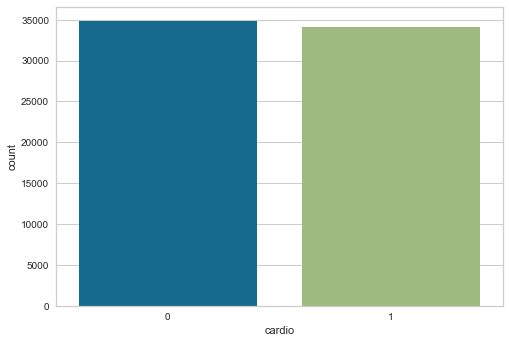

In [33]:
sns.countplot(df['cardio'])

#### From the above graph we can see our data is balanced

### Scatterplot of systolic and diastolic in terms of cardiovascular disease

<AxesSubplot:xlabel='ap_hi', ylabel='ap_lo'>

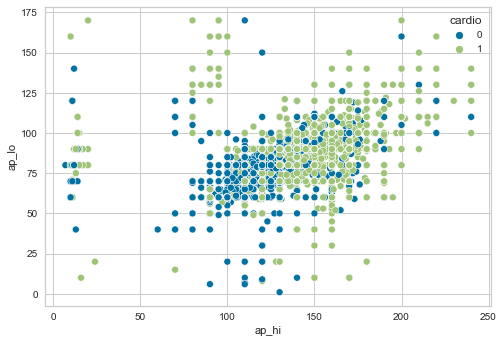

In [34]:
sns.scatterplot(x= 'ap_hi', y= 'ap_lo', hue= 'cardio', data= df)

#### We can see chances of getting cardiovascular disease increases as ap_hi and ap_lo increases. We can see positive correlation  between them

### Age Countplot

<AxesSubplot:xlabel='age', ylabel='count'>

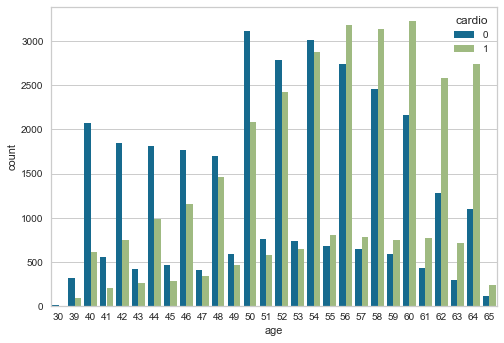

In [35]:
sns.countplot(df['age'], hue=df['cardio'])

#### From the graph we can see the chances of getting cardio vascular disease is higher as compared to not getting it from the age 55 and up 

### Categorizing age

In [36]:
df.loc[(df['age'] < 40), 'age_range'] = 30
df.loc[(df['age'] >= 40) & (df['age'] < 50), 'age_range'] = 40
df.loc[(df['age'] >= 50) & (df['age'] < 60), 'age_range'] = 50
df.loc[(df['age'] >= 60) & (df['age'] < 70), 'age_range'] = 60

### Normalizing age range

In [37]:
df['age_range'].value_counts(normalize= True)

50.0    0.504698
40.0    0.262658
60.0    0.226728
30.0    0.005916
Name: age_range, dtype: float64

### Age range countplot

<AxesSubplot:xlabel='age_range', ylabel='count'>

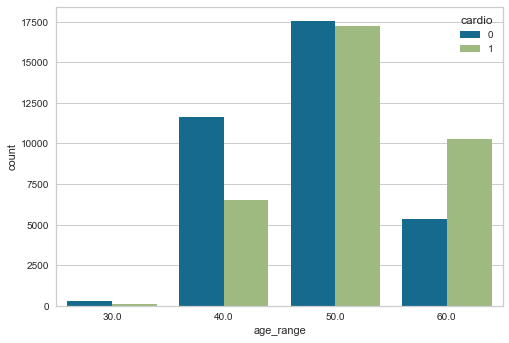

In [38]:
sns.countplot(x = 'age_range', hue = 'cardio', data= df)

#### Chances of getting cardio vascular disease is higher in 50's and 60's

### Catergorizing bmi

In [39]:
# UW: Under Weight
# NW: Normal Weight
# OWBNO: Over Weight but Not Obese
# OB: Obese
df.loc[(df['bmi'] < 18.5), 'bmi_range'] = 'UW'
df.loc[(df['bmi'] >= 18.5) & (df['bmi'] < 25), 'bmi_range'] = 'NW'
df.loc[(df['bmi'] >= 25) & (df['bmi'] < 30), 'bmi_range'] = 'OWNO'
df.loc[(df['bmi'] >= 30), 'bmi_range'] = 'OB'

### Normalizing bmi range

In [40]:
df['bmi_range'].value_counts(normalize= True)

NW      0.368519
OWNO    0.359921
OB      0.262325
UW      0.009236
Name: bmi_range, dtype: float64

### Bmi range countplot

<AxesSubplot:xlabel='bmi_range', ylabel='count'>

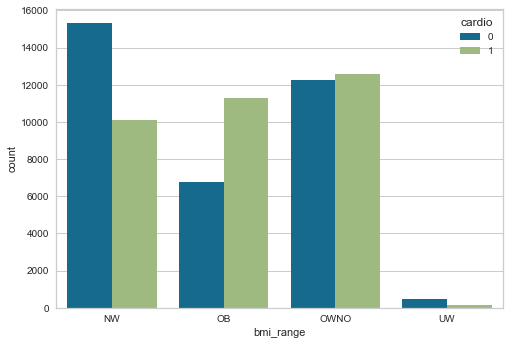

In [41]:
sns.countplot(x = 'bmi_range', hue = 'cardio', data= df)

#### As our bmi increases chances of getting cardiovascular disease increase

### Checking how gender is distributed in our data

<AxesSubplot:xlabel='gender', ylabel='count'>

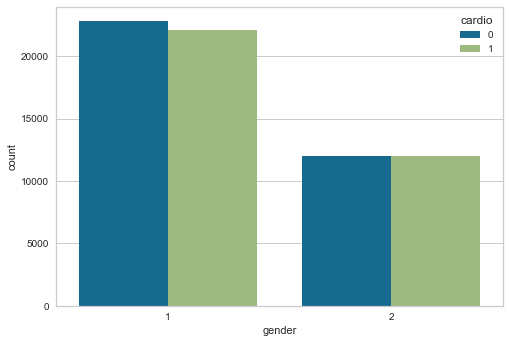

In [42]:
sns.countplot(df['gender'], hue=df['cardio'])

#### Female is denoted by 1 and male by 2. We can see from above graph in this dataset female population is almost twice to male population

### Smoke countplot

<AxesSubplot:xlabel='smoke', ylabel='count'>

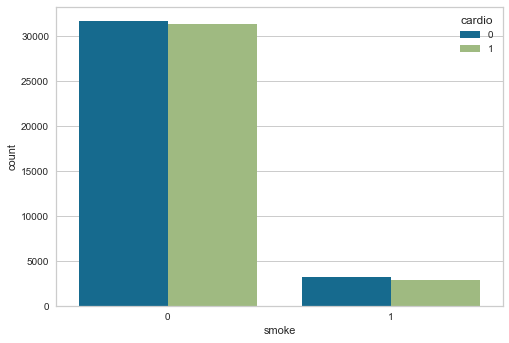

In [43]:
sns.countplot(df['smoke'], hue=df['cardio'])

#### From the above graph it looks like whether you smoke or not it hardly increases chances of getting cardio vascular disease

### Alcohol countplot

<AxesSubplot:xlabel='alco', ylabel='count'>

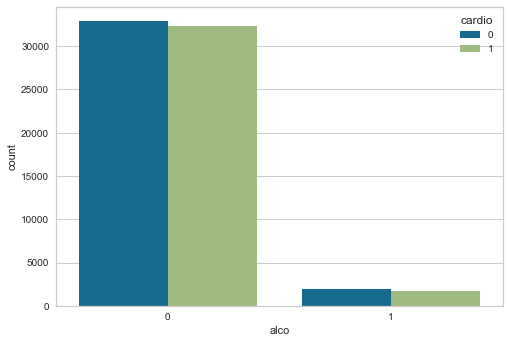

In [44]:
sns.countplot(df['alco'], hue=df['cardio'])

#### From the above graph it looks like whether you consume alcohol or not it hardly increases chances of getting cardio vascular disease

### Glucose countplot

<AxesSubplot:xlabel='gluc', ylabel='count'>

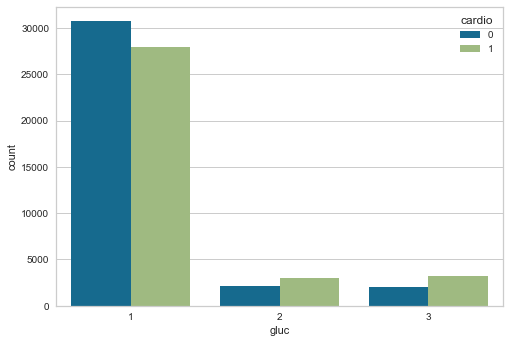

In [45]:
sns.countplot(df['gluc'], hue=df['cardio'])

#### As level of glucose increases changes of getting cardio vascular disease increases

### Exercise activity countplot

<AxesSubplot:xlabel='active', ylabel='count'>

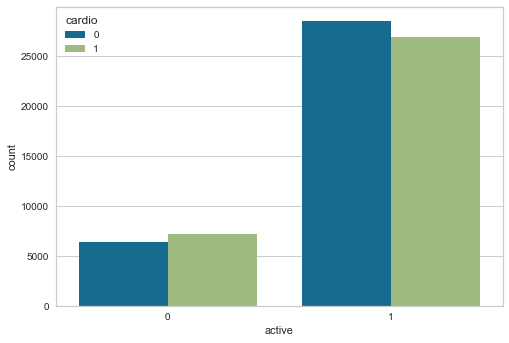

In [46]:
sns.countplot(df['active'], hue=df['cardio'])

#### If a person not involved in exercise activity chances of getting cardio vascular increases

## Feature Selection

### First thing for feature selection we have to do is to check for any correlation between variables

<AxesSubplot:>

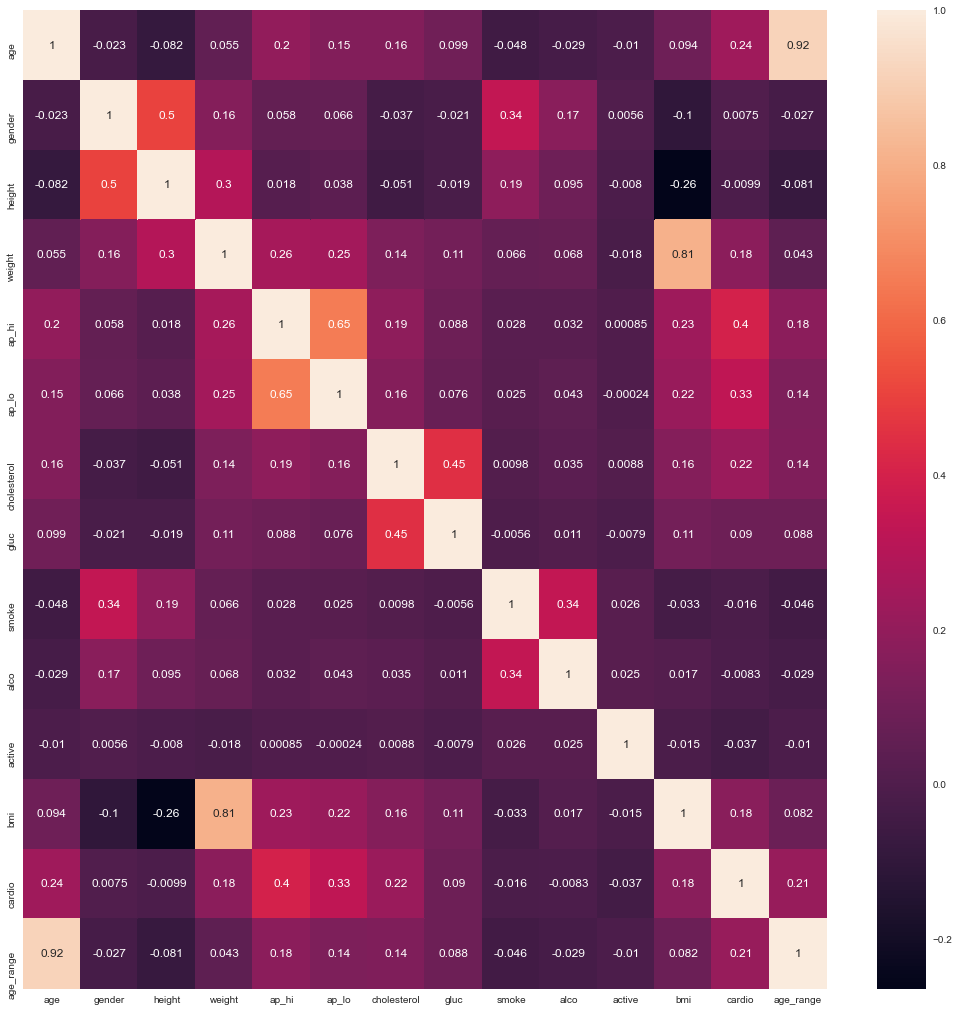

In [47]:
corrmat = df.corr()
corr_features = corrmat.index
plt.figure(figsize=(18,18))
sns.heatmap(df[corr_features].corr(), annot=True)

#### As we created bmi and age_range from height, weight and age , we can eliminate height/weight and age columns

In [48]:
df.drop(columns=['age','height', 'weight'], axis=1, inplace=True)

In [49]:
df.head()

,gender,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,bmi,cardio,age_range,bmi_range
0,2,110,80,1,1,0,0,1,21.97,0,50.0,NW
1,1,140,90,3,1,0,0,1,34.93,1,50.0,OB
2,1,130,70,3,1,0,0,0,23.51,1,50.0,NW
3,2,150,100,1,1,0,0,1,28.71,1,40.0,OWNO
4,1,100,60,1,1,0,0,0,23.01,0,40.0,NW


#### For modeling purpose we can choose either bmi/age or bmi_range/age_range because range came from bmi/age. Dropping bmi_range and age_range columns from our data

In [50]:
df.drop(columns=['bmi'], axis=1, inplace=True)

In [51]:
df.head()

,gender,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_range,bmi_range
0,2,110,80,1,1,0,0,1,0,50.0,NW
1,1,140,90,3,1,0,0,1,1,50.0,OB
2,1,130,70,3,1,0,0,0,1,50.0,NW
3,2,150,100,1,1,0,0,1,1,40.0,OWNO
4,1,100,60,1,1,0,0,0,0,40.0,NW


## Data Processing

### We can see from above data that (gender, cholesterol, gluc, smoke, alco, active) variables are categorical and we need to change them in dummy variables and scaling the values before we use any machine learning models

In [52]:
df1 = pd.get_dummies(df, columns=['gender','cholesterol', 'gluc', 'smoke', 'alco', 'active', 'bmi_range', 'age_range'])

In [53]:
df1.head()

,ap_hi,ap_lo,cardio,gender_1,gender_2,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,...,active_0,active_1,bmi_range_NW,bmi_range_OB,bmi_range_OWNO,bmi_range_UW,age_range_30.0,age_range_40.0,age_range_50.0,age_range_60.0
0,110,80,0,0,1,1,0,0,1,0,...,0,1,1,0,0,0,0,0,1,0
1,140,90,1,1,0,0,0,1,1,0,...,0,1,0,1,0,0,0,0,1,0
2,130,70,1,1,0,0,0,1,1,0,...,1,0,1,0,0,0,0,0,1,0
3,150,100,1,0,1,1,0,0,1,0,...,0,1,0,0,1,0,0,1,0,0
4,100,60,0,1,0,1,0,0,1,0,...,1,0,1,0,0,0,0,1,0,0


In [54]:
stdScaler = StandardScaler()
# Rest of the columns that are not converted into dummy variables, excluding target variable for scaling
col_to_scale = ['ap_hi', 'ap_lo']
df1[col_to_scale]= stdScaler.fit_transform(df1[col_to_scale])

In [55]:
df1.head()

,ap_hi,ap_lo,cardio,gender_1,gender_2,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,...,active_0,active_1,bmi_range_NW,bmi_range_OB,bmi_range_OWNO,bmi_range_UW,age_range_30.0,age_range_40.0,age_range_50.0,age_range_60.0
0,-0.922417,-0.13735,0,0,1,1,0,0,1,0,...,0,1,1,0,0,0,0,0,1,0
1,0.773077,0.88805,1,1,0,0,0,1,1,0,...,0,1,0,1,0,0,0,0,1,0
2,0.207912,-1.16275,1,1,0,0,0,1,1,0,...,1,0,1,0,0,0,0,0,1,0
3,1.338242,1.91345,1,0,1,1,0,0,1,0,...,0,1,0,0,1,0,0,1,0,0
4,-1.487581,-2.18815,0,1,0,1,0,0,1,0,...,1,0,1,0,0,0,0,1,0,0


In [56]:
# Since gender, smoker, alcohol consumption and actively involve doing exercise columns are yes and no basis
# we can drop for instance either gender_1 or gender_2 because they give us same information.
df1.drop(columns=['gender_1', 'smoke_0', 'alco_0', 'active_0'], axis=1, inplace=True)

### Creating dependent and independent features

In [57]:
X = df1.drop(['cardio'], axis=1)
y = df1['cardio']
print('Shape of X is :', X.shape, 'Shape of y is :', y.shape)

Shape of X is : (68968, 20) Shape of y is : (68968,)


## KNN model

In [58]:
knn_scores = []
for k in range(1,21):
    knn_classifier = KNeighborsClassifier(n_neighbors = k)
    score=cross_val_score(knn_classifier,X,y,cv=10)
    knn_scores.append(score.mean())

Text(0.5, 1.0, 'K Neighbors Classifier scores for different K values')

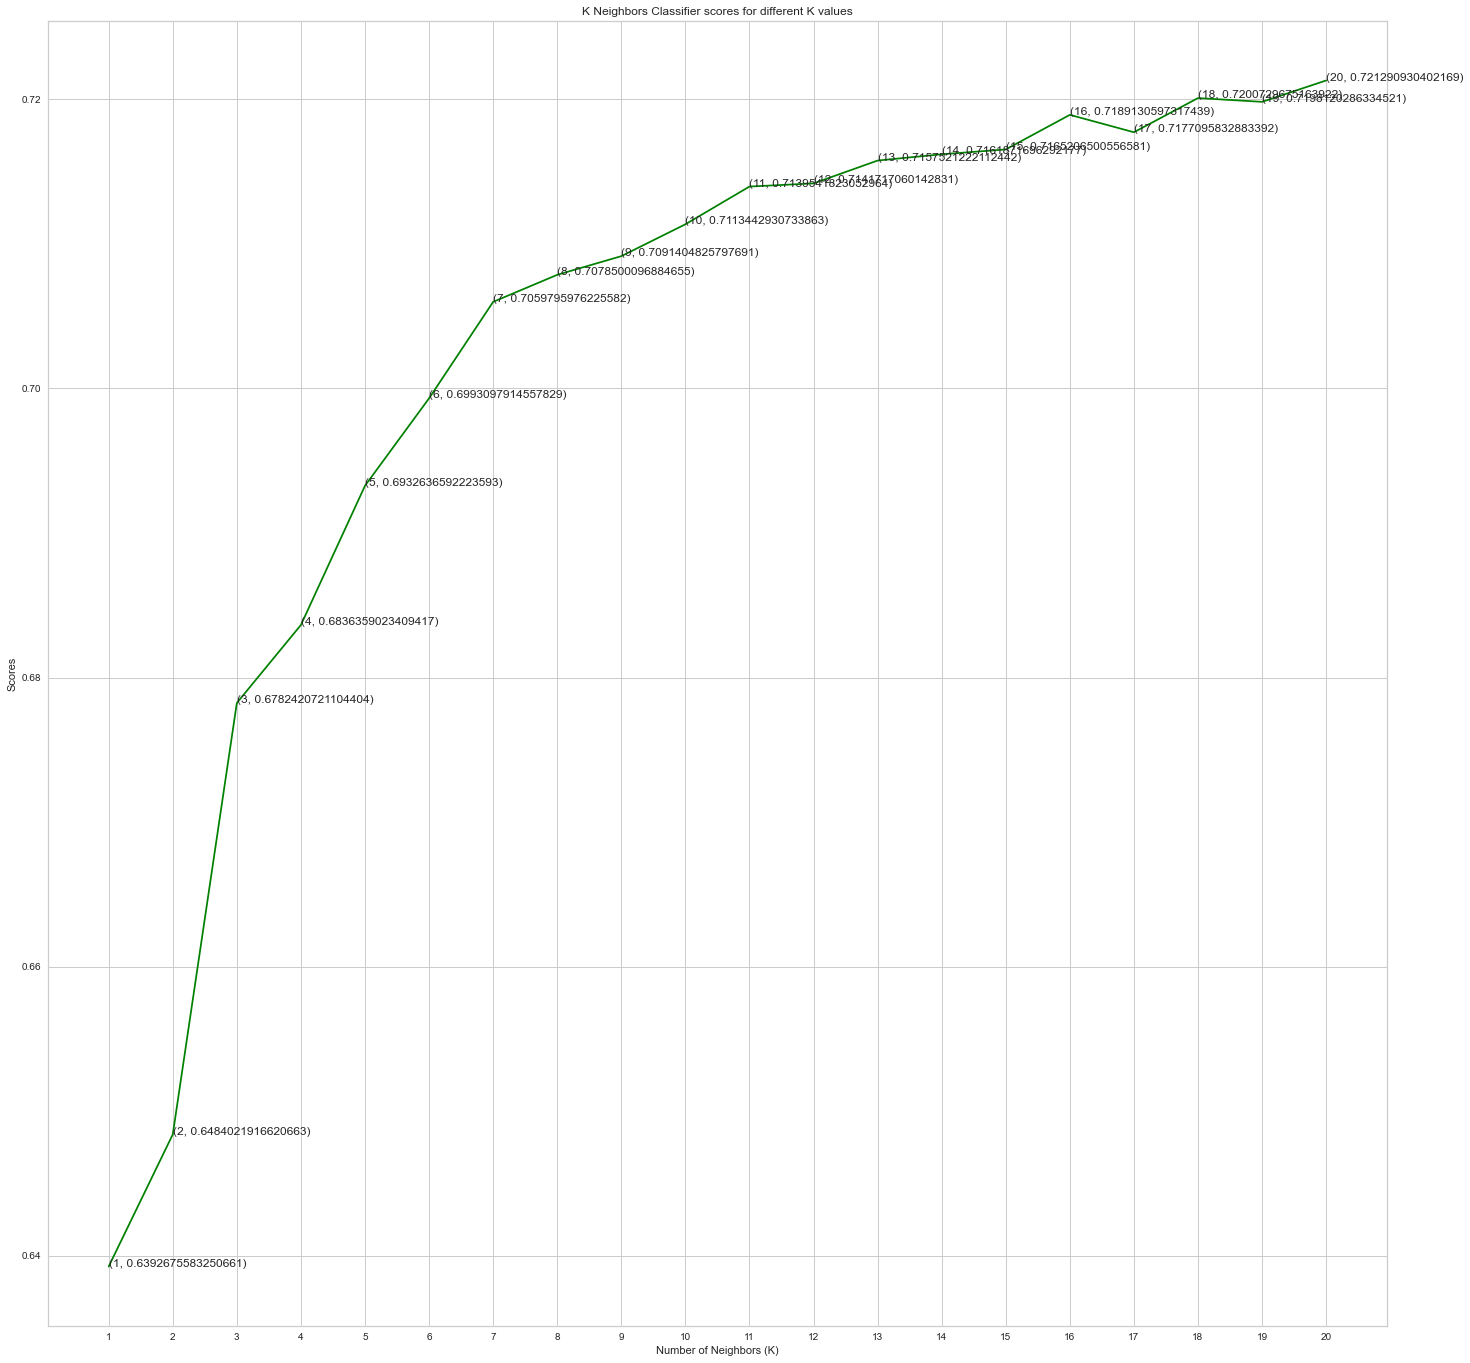

In [59]:
plt.figure(figsize=(24,24))
plt.plot([k for k in range(1, 21)], knn_scores, color = 'green')
for i in range(1,21):
    plt.text(i, knn_scores[i-1], (i, knn_scores[i-1]))
plt.xticks([i for i in range(1, 21)])
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Scores')
plt.title('K Neighbors Classifier scores for different K values')

In [60]:
knn_classifier = KNeighborsClassifier(n_neighbors = 20)
score = cross_val_score(knn_classifier,X,y,cv=10)

In [61]:
sc = round(score.mean() * 100, 2)
print(f'Accuracy score by using knn model is: {sc} %')

Accuracy score by using knn model is: 72.13 %


In [62]:
# Train test split 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

## Logistic Regression

In [63]:
lr = LogisticRegression(solver='liblinear')
samp = lr.fit(X_train, y_train)
samp_pred = samp.predict(X_test)
lr.score(X_test, y_test)

0.730680005799623

In [64]:
print('Model Accuracy: {:.2f}%'.format(np.mean(samp_pred == y_test) * 100))
print('Precision: {:.2f}%'.format(precision_score(y_test, samp_pred, average="macro")*100))
print('Recall: {:.2f}%'.format(recall_score(y_test, samp_pred, average="macro")*100))
print('F-score: {:.2f}%'.format(f1_score(y_test, samp_pred, average="macro")*100))

Model Accuracy: 73.07%
Precision: 73.29%
Recall: 73.02%
F-score: 72.98%


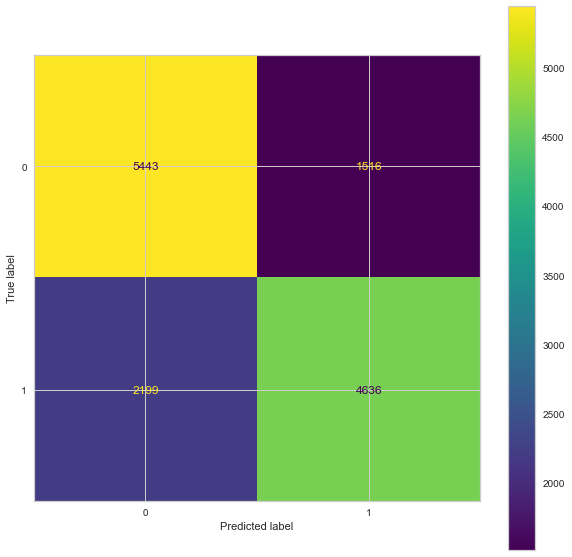

In [65]:
# Computing Confusion Matrix to evaluate the accuracy of a classification
cm2 = confusion_matrix(y_test, samp_pred)
cm2
# Plotting confusion matrix
fig, ax = plt.subplots(figsize=(10,10))
fig = ConfusionMatrixDisplay(confusion_matrix=cm2)
fig.plot(ax=ax)
plt.show()

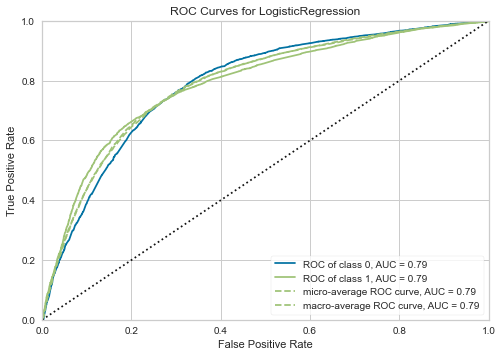

In [66]:
# ROC and AUC
#Instantiate the visualizer
visualizer = ROCAUC(lr)
# Fit the training data to the visualizer
visualizer.fit(X_train, y_train)
# Evaluate the model on the test data
visualizer.score(X_test, y_test)  
# poof is called to display the image
g = visualizer.poof()

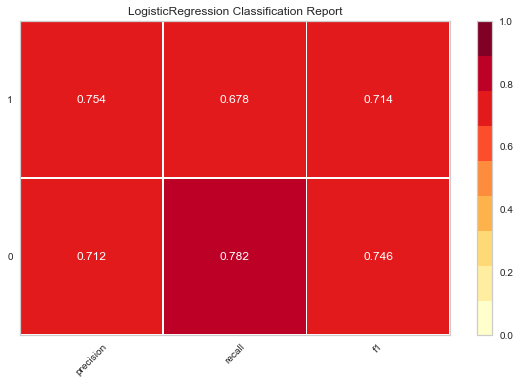

In [67]:
# Instantiate the visualizer
visualizer = ClassificationReport(lr)
# Fit the training data to the visualizer
visualizer.fit(X_train, y_train)  
# Evaluate the model on the test data
visualizer.score(X_test, y_test) 
# poof is called to display the image
g = visualizer.poof()

In [68]:
score2 = cross_val_score(LogisticRegression(), X,y, cv=10)

In [69]:
sc2 = round(score2.mean() * 100, 2)
print(f'Accuracy score by using logistic regression model is: {sc2} %')

Accuracy score by using logistic regression model is: 72.71 %


## Decision Tree

In [70]:
tree = DecisionTreeClassifier(max_depth = 10, random_state = 10)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, random_state=10)

In [71]:
y_predict = tree.predict(X_test)
print(accuracy_score(y_test, y_predict),
     f1_score(y_test, y_predict, average = 'micro'))

0.7316949398289111 0.7316949398289111


In [72]:
kf= KFold(n_splits = 5, shuffle = True, random_state = 50)

In [73]:
tree_params = {'max_depth':np.arange(2,11), 'min_samples_split':np.arange(2,10),
              'min_samples_leaf':np.arange(1,10), 'max_features':np.arange(1,10)
              }
tree_grid = GridSearchCV(tree, tree_params, cv=5, scoring='accuracy')
tree_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=10, random_state=10),
             param_grid={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'max_features': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'min_samples_split': array([2, 3, 4, 5, 6, 7, 8, 9])},
             scoring='accuracy')

In [74]:
tree_grid.best_params_

{'max_depth': 5,
 'max_features': 9,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [75]:
tree_grid.best_score_

0.728513360565551

In [76]:
optimal_tree = DecisionTreeClassifier(max_depth = 5 , max_features = 9 ,
                                     min_samples_leaf = 1 , min_samples_split = 2 ,
                                     random_state = 10)

In [77]:
optimal_tree.fit(X_train, y_train)
y_preds = optimal_tree.predict(X_test)
print(accuracy_score(y_test, y_preds))

0.7362621429607076


## Random Forest Classifier

In [78]:
rf = RandomForestClassifier(n_estimators = 100)
samp3 = rf.fit(X_train, y_train)
samp_pred3 = samp3.predict(X_test)
rf.score(X_test, y_test)

0.7192982456140351

In [79]:
print('Model Accuracy: {:.2f}%'.format(np.mean(samp_pred3 == y_test) * 100))
print('Precision: {:.2f}%'.format(precision_score(y_test, samp_pred3, average="macro")*100))
print('Recall: {:.2f}%'.format(recall_score(y_test, samp_pred3, average="macro")*100))
print('F-score: {:.2f}%'.format(f1_score(y_test, samp_pred3, average="macro")*100))

Model Accuracy: 71.93%
Precision: 72.04%
Recall: 71.90%
F-score: 71.87%


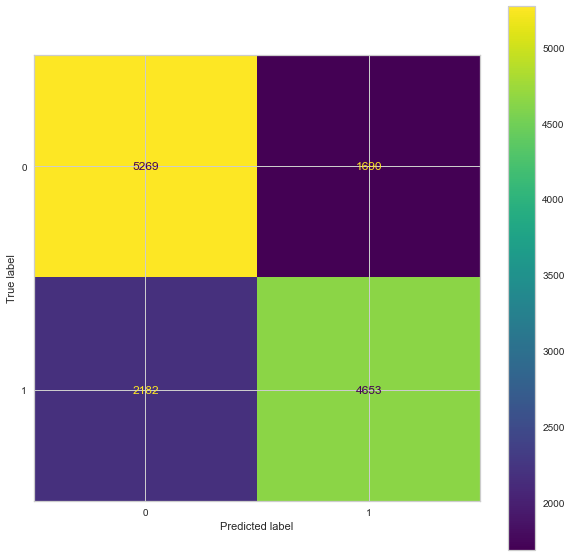

In [80]:
# Computing Confusion Matrix to evaluate the accuracy of a classification
cm4 = confusion_matrix(y_test, samp_pred3)
cm4
# Plotting confusion matrix
fig, ax = plt.subplots(figsize=(10,10))
fig = ConfusionMatrixDisplay(confusion_matrix=cm4)
fig.plot(ax=ax)
plt.show()

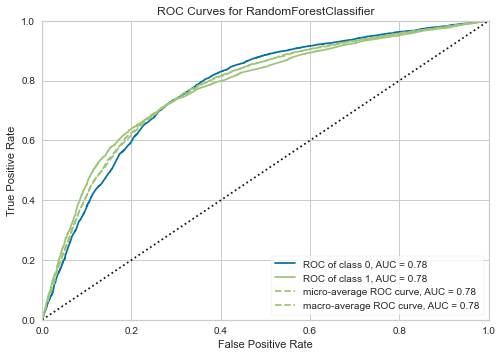

In [81]:
# ROC and AUC
#Instantiate the visualizer
visualizer = ROCAUC(rf)
# Fit the training data to the visualizer
visualizer.fit(X_train, y_train)
# Evaluate the model on the test data
visualizer.score(X_test, y_test)  
# poof is called to display the image
g = visualizer.poof()

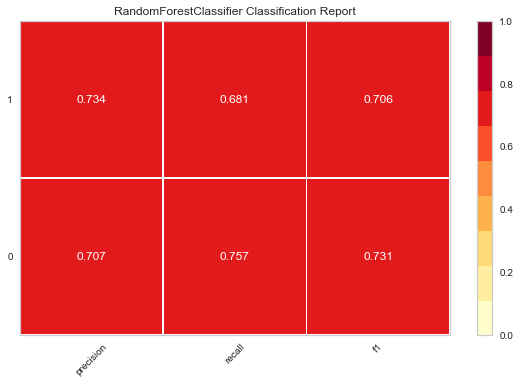

In [82]:
# Instantiate the visualizer
visualizer = ClassificationReport(rf)
# Fit the training data to the visualizer
visualizer.fit(X_train, y_train)  
# Evaluate the model on the test data
visualizer.score(X_test, y_test) 
# poof is called to display the image
g = visualizer.poof()

In [83]:
score4 = cross_val_score(RandomForestClassifier(), X,y, cv=10)

In [84]:
sc4 = round(score4.mean() * 100, 2)
print(f'Accuracy score by using Random Forest model is: {sc4} %')

Accuracy score by using Random Forest model is: 71.48 %


## XGBoost

In [85]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', seed=50)
clf_xgb.fit(X_train,
           y_train, 
           verbose=True,
           early_stopping_rounds=10,
           eval_metric='aucpr',
           eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.77720
[1]	validation_0-aucpr:0.77884
[2]	validation_0-aucpr:0.78026
[3]	validation_0-aucpr:0.77992
[4]	validation_0-aucpr:0.78057
[5]	validation_0-aucpr:0.78183
[6]	validation_0-aucpr:0.78012
[7]	validation_0-aucpr:0.78032
[8]	validation_0-aucpr:0.78239
[9]	validation_0-aucpr:0.78304
[10]	validation_0-aucpr:0.78230
[11]	validation_0-aucpr:0.78273
[12]	validation_0-aucpr:0.78262
[13]	validation_0-aucpr:0.78272
[14]	validation_0-aucpr:0.78234
[15]	validation_0-aucpr:0.78214
[16]	validation_0-aucpr:0.78236
[17]	validation_0-aucpr:0.78254
[18]	validation_0-aucpr:0.78226


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=50,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=50,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

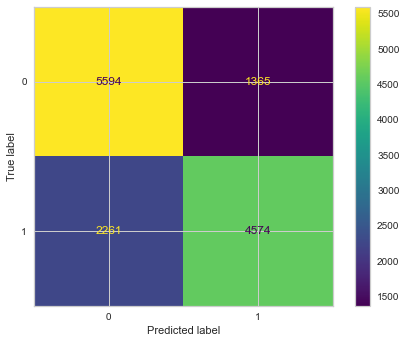

In [86]:
plot_confusion_matrix(clf_xgb,
                     X_test, 
                     y_test)

Model accuracy = (5594+4574)/(5594+4574+2261+1365) = 0.7371 which is 73.71%.

## Based on all the models used, XGBoost and Decision Tree gave me best result of 73.71% and 73.62% respectively. All the models were in between 72-74%. The model will predict whether or not person will get a cardiovascular disease or not based on information inputted by them. If it shows that person will get it then it will be the best time to change with healthy habits and consult doctor immediately for further guidance. 